# Image Captioning using ViT and GPT2
The goal of this notebook is to find accurate descriptions about the person displayed on an image. To do this, we can use a combination of both the ViT and the GPT2 model.  
ViT is a visual model based on the architecture of a transformer originally designed for text-based tasks. The model represents an input image as a series of image patches, like the series of word embeddings used when using transformers to text, and directly predicts class labels for the image.  
GPT-2 is a large transformer-based language model with 1.5 billion parameters, trained on a dataset of 8 million webpages.

In [1]:
from datasets import Dataset, DatasetDict
import pandas as pd
import random
from pathlib import Path
from IPython.display import display
from PIL import Image

In [2]:
MODEL = "nlpconnect/vit-gpt2-image-captioning"
MAX_LENGTH = 25
NUM_BEAMS = 4
gen_kwargs = {"max_length": MAX_LENGTH, "num_beams": NUM_BEAMS}

## Set up the data set
RSTPReid contains 20505 images of 4101 persons from 15 cameras. Each person has 5 corresponding images taken by different cameras with complex both indoor and outdoor scene transformations and backgrounds in various periods of time. Each image is annotated with 2 textual descriptions.

In [3]:
dataset_base_path = Path().resolve().parent / 'RSTPReid'
image_path = dataset_base_path / 'imgs'

### Splitting the data set
The dataset should be split into a train, test, and validation set. Luckily, the dataset has already done this for us.

In [4]:
def splitDataSet():
    description = dataset_base_path / 'data_captions.json'
    if not description.exists():
        raise FileNotFoundError(f"Couldn't find the description file at {description}.")
    df = pd.read_json(description)
    df['img_path'] = image_path / df['img_path']
    df['img_path'] = df['img_path'].astype('str')
    df.loc[:, 'captions'] = df.captions.map(lambda x: x[0])
    train, val, test = df[df['split'] == 'train'], df[df['split'] == 'val'], df[df['split'] == 'test']
    return train.reset_index(drop=True), val.reset_index(drop=True), test.reset_index(drop=True)

In [5]:
def convertDataSet(df):
    new = df[['img_path', 'captions']]
    dataset = Dataset.from_dict(new)
    return dataset

In [6]:
train_df, val_df, test_df = splitDataSet()
dataset_dict = DatasetDict({"train": convertDataSet(train_df), "val": convertDataSet(val_df), "test": convertDataSet(test_df)})

In [7]:
print(f"Number of training examples: {len(dataset_dict['train'])}")
print(f"Number of validation examples: {len(dataset_dict['val'])}")
print(f"Number of test examples: {len(dataset_dict['test'])}")

Number of training examples: 18505
Number of validation examples: 1000
Number of test examples: 1000


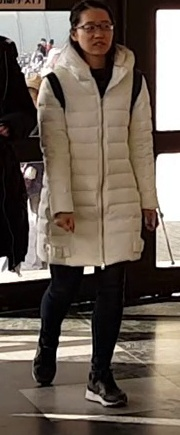

Here is a lady wearing a white long down jacket, black trousers and a pair of black shoes. She is walking with a backpack on her back.


In [8]:
random_sample = random.randint(0, len(dataset_dict['train']))
example = dataset_dict['train'][random_sample]

img = Image.open(example['img_path'])
display(img)
img.close()
print(example['captions'])

## Set up the base model

In [9]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
import numpy as np
import evaluate
from tqdm import tqdm
import nltk
try:
    nltk.data.find("tokenizers/punkt")
except (LookupError, OSError):
    nltk.download("punkt", quiet=True)

2023-04-16 08:51:02.308087: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 08:51:03.804866: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-16 08:51:07.336855: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/leuven/icelake/2021a/software/CUDA/11.7.1/nvvm/lib64:/apps/leuven/icelake/2021a/s

In [10]:
base_model = VisionEncoderDecoderModel.from_pretrained(MODEL)
feature_extractor = ViTImageProcessor.from_pretrained(MODEL)
tokenizer = AutoTokenizer.from_pretrained(MODEL)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
base_model = base_model.to(device)

In [11]:
def preprocess_image(img_paths):
    images = []
    for img_path in img_paths:
        i_image = Image.open(img_path)
        if i_image.mode != "RGB":
            i_image = i_image.convert(mode="RGB")
        images.append(i_image)
    pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    return pixel_values

In [12]:
def predict(model, pixel_values):
    output_ids = model.generate(pixel_values, **gen_kwargs)
    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    return preds

## Investigating the Base Behaviour of the model (without retraining any layers)
Start by predicting the example image

In [13]:
pixel_values = preprocess_image([example['img_path']])
preds = predict(base_model, pixel_values)
print(preds)

['a woman standing in front of a wall holding a cell phone']


### Define an evaluation metric
I've chosen the ROUGE metrics, as they are used for machine translation and summaries. Alternatives would be BLUE, NIST, METEOR, and WER (but that last one is bad).

In [14]:
metric = evaluate.load("rouge")

In [15]:
def postprocess_text(list_of_sentences, separator='\n'):
    list_of_sentences = [sentence.strip() for sentence in list_of_sentences]
    if separator is not None:
        tokens = ["\n".join(nltk.sent_tokenize(sentence)) for sentence in list_of_sentences]
    else:
        tokens = [nltk.sent_tokenize(sentence) for sentence in list_of_sentences]
    return tokens

In [16]:
def compute_metrics(predictions, labels):
    preds, lbls = postprocess_text(predictions), postprocess_text(labels)
    result = metric.compute(predictions=preds, references=lbls, use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    return result

### Make predictions for all examples in the validation set and calculate the metrics.

In [20]:
total_score = 0

# for example in tqdm(dataset_dict["val"]):
#     pixel_values = preprocess_image([example["img_path"]])
#     prediction = predict(base_model, pixel_values)
#     score = compute_metrics(prediction, [example['captions']])
#     total_score += score["rougeL"]

100%|██████████| 1000/1000 [07:06<00:00,  2.34it/s]


In [21]:
print(f"The average RougeL score of the base model on the validation set was: {total_score / 1000}")

The average RougeL score of the base model on the validation set was: 19.347239599999995


## FineTune the ViT encoder

In [21]:
from transformers import TrainingArguments, Trainer

In [19]:
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [22]:
trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["val"],
    compute_metrics=compute_metrics,
)

In [24]:
trainer.train()

/data/leuven/351/vsc35135/miniconda3/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


IndexError: Invalid key: 14138 is out of bounds for size 0